In [70]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [3]:
pip install scikit-learn==0.23.1 # 이 버전에서만 IterativeImputer 지원됨

     |████████████████████████████████| 6.8MB 10.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [71]:
import pandas as pd
import numpy as np

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 불러오기

In [24]:
path = "/content/drive/Shareddrives/Multicampus/Preprocessing/"
dummy = pd.read_csv(path+"0414_dummy(최종).csv")
pivot12_mnmx_ind = pd.read_csv(path+'pivot12_mnmx_ind.csv')
pivot12_under = pd.read_csv(path+"pivot12_mnmx_under.csv")
pivot12_under_ind = pd.read_csv(path+"pivot12_mnmx_under_ind.csv")

In [26]:
dummy.drop(['new_code','AGEG1','AGEG2'],inplace=True, axis=1)

In [73]:
# undersampling 전
dummy_pivot12_ind=dummy.merge(pivot12_mnmx_ind, on='SUBJECT_ID', how='inner')

In [74]:
dummy_pivot12_ind.shape

(27689, 147)

In [76]:
print(len(dummy_pivot12_ind[dummy_pivot12_ind.HOSPITAL_EXPIRE_FLAG == 1]))
print(len(dummy_pivot12_ind[dummy_pivot12_ind.HOSPITAL_EXPIRE_FLAG == 0]))

3682
24007


# 공통된 SUBJECT_ID로 맞추기

In [6]:
u_dummy = pd.merge(dummy, pivot12_under['SUBJECT_ID'], how='right', on='SUBJECT_ID')
u_dummy_pivot12 = pd.merge(dummy, pivot12_under, how='inner', on='SUBJECT_ID')
u_dummy_pivot12_ind = pd.merge(dummy, pivot12_under_ind, how='inner', on='SUBJECT_ID')

In [77]:
print(len(u_dummy_pivot12_ind[u_dummy_pivot12_ind.HOSPITAL_EXPIRE_FLAG == 1]))
print(len(u_dummy_pivot12_ind[u_dummy_pivot12_ind.HOSPITAL_EXPIRE_FLAG == 0]))

3682
5260


# 함수 import

In [7]:
# pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

# model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# scoring
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# train-test 분리 

## 정규화/표준화 X

In [8]:
def train_test_original(data):
  # X, y 분리
  X = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)
  y = data['HOSPITAL_EXPIRE_FLAG']
  col_names = list(X.columns)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  
  return X_train, X_test, y_train, y_test, col_names

In [28]:
X_train, X_test, y_train, y_test, col_names = train_test_original(dummy_pivot12_ind)

NameError: ignored

## 정규화/표준화 O

In [8]:
def train_test_scaler(data, scaler=StandardScaler()):
  # X, y 분리
  X = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)
  y = data['HOSPITAL_EXPIRE_FLAG']
  col_names = X.columns
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # scaler
  sc = scaler
  sc.fit(X_train)
  X_train = sc.transform(X_train)
  X_test = sc.transform(X_test)
  
  return X_train, X_test, y_train, y_test, col_names

In [29]:
X_train, X_test, y_train, y_test, col_names = train_test_scaler(dummy_pivot12_ind)

# scoring 설정

In [30]:
scores = {'AUC': 'roc_auc', 
          'Accuracy': make_scorer(accuracy_score), 
          'precision':make_scorer(precision_score, average='micro'), 
          'recall': make_scorer(recall_score, average='micro'),
          'f1-score':make_scorer(f1_score, average='micro')}

# Grid_model 설정

## RandomForestClassifier

In [31]:
def grid_rf():
  param_grid = [
                {'max_depth':[5,7], 
                'n_estimators':[500,700,1000]}
                ]

  grid = GridSearchCV(estimator = RandomForestClassifier(random_state = 42), 
                      param_grid = param_grid, 
                      scoring = scores,
                      refit='f1-score', 
                      n_jobs = -1,
                      cv = 5)  # refit: fit 기준 

  return param_grid, grid

## SVC

In [11]:
def grid_svc():
  param_grid = [
                # {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                {'C': [10, 100, 1000], 'gamma': [0.01, 0.001], 'kernel': ['rbf']},              
                # {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['sigmoid']}, # 별로임
                ]

  grid = GridSearchCV(estimator = SVC(cache_size = 500, random_state = 42), 
                      param_grid = param_grid, 
                      scoring = scores,
                      refit='f1-score', 
                      n_jobs = -1,
                      cv = 5)  # refit: fit 기준 

  return param_grid, grid

## Logistic Regression

In [12]:
def grid_lr():
  param_grid = [
                {'C':[0.01, 0.1, 1, 10], 
                'max_iter':[500,700,1000]}
                ]

  grid = GridSearchCV(estimator = LogisticRegression(random_state = 42), 
                      param_grid = param_grid, 
                      scoring = scores,
                      refit='f1-score', 
                      n_jobs = -1,
                      cv = 5)

  return param_grid, grid

## KNN

In [13]:
def grid_knn():
  param_grid = [
                {'n_neighbors':[1,3,5,7,9,11,13,15,17,19]}
                ]

  grid = GridSearchCV(estimator = KNeighborsClassifier, 
                      param_grid = param_grid, 
                      scoring = scores,
                      refit='f1-score', 
                      n_jobs = -1,
                      cv = 5)

  return param_grid, grid

## Decision Tree

In [14]:
def grid_dt():
  param_grid = [
                {'max_depth':[1,5,7]}
                ]

  grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42), 
                      param_grid = param_grid, 
                      scoring = scores,
                      refit='f1-score', 
                      n_jobs = -1,
                      cv = 5)

  return param_grid, grid

# Imputers

## KNNImputer

In [31]:
def optimize_k_mortality(split, model):
  for k in range(1, 20, 2):
    X_train, X_test, y_train, y_test, col_names = split
    imputer = KNNImputer(n_neighbors=k)
    imputed_tr = imputer.fit_transform(X_train)
    imputed_ts = imputer.fit_transform(X_test)
    X_train = pd.DataFrame(imputed_tr, columns=col_names)
    X_test = pd.DataFrame(imputed_ts, columns=col_names)

    param_grid, grid = model
    grid.fit(X_train, y_train)

    # estimator = grid.best_estimator_
    y_pred = grid.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*20)
    print('k :',k)
    print('model:',estimator)
    print('오차 행렬: ')
    print(confusion)
    print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
    print('-'*20)

In [40]:
optimize_k_mortality(train_test_scaler(u_dummy_pivot12_ind), grid_knn())

TypeError: ignored

## MICE

In [35]:
def mice(split, model, mice_estimator=BayesianRidge()):
    X_train, X_test, y_train, y_test, col_names = split

    imputer = IterativeImputer(mice_estimator, 
                               n_nearest_features=11, 
                               random_state=42,
                               sample_posterior=True)
    imputed_tr = imputer.fit_transform(X_train)
    imputed_ts = imputer.fit_transform(X_test)
    X_train = pd.DataFrame(imputed_tr, columns=col_names)
    X_test = pd.DataFrame(imputed_ts, columns=col_names)    
        
    param_grid, grid = model
    grid.fit(X_train, y_train)

    estimator = grid.best_estimator_
    y_pred = estimator.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    df = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_f1-score'], ascending=True).head()

    print('-'*20)
    print(df)
    print('model:',estimator)
    print('오차 행렬: ')
    print(confusion)
    print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
    print('-'*20)
    return df

In [43]:
mice(train_test_scaler(u_dummy_pivot12_ind), grid_dt())

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


--------------------
   mean_fit_time  std_fit_time  ...  std_test_f1-score  rank_test_f1-score
2       0.175895      0.003207  ...           0.010901                   1
1       0.134410      0.004455  ...           0.008979                   2
0       0.037318      0.003238  ...           0.009052                   3

[3 rows x 46 columns]
model: DecisionTreeClassifier(max_depth=7, random_state=42)
오차 행렬: 
[[1240  337]
 [ 417  689]]
AUC:  0.7046, 정확도: 0.7190, 정밀도: 0.6715, 재현율: 0.6230, F1 socre: 0.6463
--------------------


## mean

In [33]:
def mean(split, model, strategy='mean'):
    X_train, X_test, y_train, y_test, col_names = split

    imputer = SimpleImputer(strategy=strategy)
    imputed_tr = imputer.fit_transform(X_train)
    imputed_ts = imputer.fit_transform(X_test)
    X_train = pd.DataFrame(imputed_tr, columns=col_names)
    X_test = pd.DataFrame(imputed_ts, columns=col_names)    
        
    param_grid, grid = model
    grid.fit(X_train, y_train)

    # estimator = grid.best_estimator_
    y_pred = grid.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*20)
    print('model:',grid.get_params)
    print('오차 행렬: ')
    print(confusion)
    print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
    print('-'*20)

In [34]:
mean(train_test_scaler(dummy_pivot12_ind), grid_rf())

--------------------
model: <bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
             param_grid=[{'max_depth': [5

In [42]:
y_test[y_test==0]

4871     0
10519    0
17279    0
16102    0
22732    0
        ..
19095    0
26005    0
14032    0
5896     0
15840    0
Name: HOSPITAL_EXPIRE_FLAG, Length: 7186, dtype: int64

# Feature Selection
https://velog.io/@vvakki_/%EB%9E%9C%EB%8D%A4-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8%EC%97%90%EC%84%9C%EC%9D%98-%EB%B3%80%EC%88%98-%EC%A4%91%EC%9A%94%EB%8F%84Variable-Importance-3%EA%B0%80%EC%A7%80

## MDI
(Mean Decrease in Impurity)

In [51]:
X_train, X_test, y_train, y_test, col_names = train_test_scaler(u_dummy_pivot12_ind)

imputer = SimpleImputer()
imputed_tr = imputer.fit_transform(X_train)
imputed_ts = imputer.fit_transform(X_test)
X_train = pd.DataFrame(imputed_tr, columns=col_names)
X_test = pd.DataFrame(imputed_ts, columns=col_names)

In [52]:
rf = RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [53]:
features = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'], axis=1).columns.values
mdi_feat_imp = pd.DataFrame({'features':features, 'importances':rf.feature_importances_}).sort_values(by=['importances'], ascending=False)
mdi_feat_imp_30 = mdi_feat_imp.sort_values(by=['importances'], ascending=False).head(30)

In [54]:
lab_names={'50820':"pH", '50868':'Anion Gap', '50882':'Bicarbonate', '50893':'Calcium', '50902':'Chloride', '50912':'Creatinine',
       '50931':'Glucose', '50960':'Magnesium', '50970':'Phosphate', '50971':'Potassium', '50983':'Sodium', '51006':'Urea Nitrogen', '51200':'Eosinophils', '51221':'Hematocrit',
       '51222':'Hemoglobin', '51254':'Monocytes', '51256':'Neutrophils', '51265':'Platelet Count', '51275':'PTT', '51279':'RBC', '51301':'WBC'}

lab_labels = []
for i in mdi_feat_imp_30['features']:
  if i[0:5] in lab_names.keys():
    i = lab_names[i[0:5]] + i[5:]
    lab_labels.append(i)
  else: 
    lab_labels.append(i)

In [55]:
fig = plt.figure(figsize=(8,10))
ax = sns.barplot(mdi_feat_imp_30['importances'],mdi_feat_imp_30['features'], palette='GnBu_d')
ax.set_yticklabels(lab_labels, fontsize=10)

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()))
  initialx+=1

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [64]:
fig.savefig(path+'RF_feature_importance_top30.png')

## Permutation

In [103]:
rf = RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
sklearn_perm = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)

In [104]:
features = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'], axis=1).columns.values
sklearn_perm_imp = pd.DataFrame({'features':features, 'importances':sklearn_perm.importances_mean})
sklearn_perm_imp = sklearn_perm_imp.sort_values(by=['importances'], ascending=False)
sklearn_perm_imp_30=sklearn_perm_imp.head(30)

In [105]:
lab_names={'50820':"pH", '50868':'Anion Gap', '50882':'Bicarbonate', '50893':'Calcium', '50902':'Chloride', '50912':'Creatinine',
       '50931':'Glucose', '50960':'Magnesium', '50970':'Phosphate', '50971':'Potassium', '50983':'Sodium', '51006':'Urea Nitrogen', '51200':'Eosinophils', '51221':'Hematocrit',
       '51222':'Hemoglobin', '51254':'Monocytes', '51256':'Neutrophils', '51265':'Platelet Count', '51275':'PTT', '51279':'RBC', '51301':'WBC'}

lab_labels = []
for i in sklearn_perm_imp_30['features']:
  if i[0:5] in lab_names.keys():
    i = lab_names[i[0:5]] + i[5:]
    lab_labels.append(i)
  else: 
    lab_labels.append(i)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


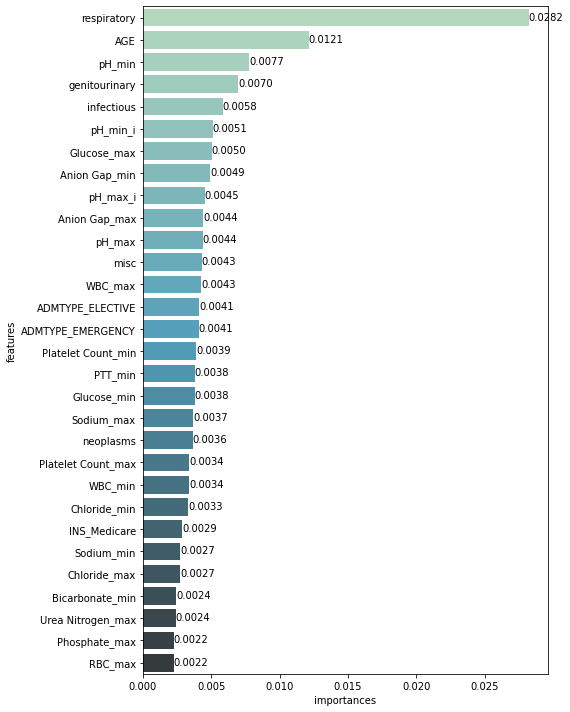

In [106]:
fig = plt.figure(figsize=(8,10))
ax = sns.barplot(sklearn_perm_imp_30['importances'],sklearn_perm_imp_30['features'], palette='GnBu_d')
ax.set_yticklabels(lab_labels, fontsize=10)

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.4f}'.format(p.get_width()))
  initialx+=1

plt.tight_layout()
plt.show()

In [49]:
fig.savefig(path+'(수정)RF_permutation_importance_top30.png')

### feature 선정

In [107]:
perm_idx = list(sklearn_perm_imp_30.index)
mdi_idx = list(mdi_feat_imp_30.index)
inter_idx = list(set(sklearn_perm_imp_30.index) & set(mdi_feat_imp_30.index)) # 교집합
union_idx = list(set(sklearn_perm_imp_30.index) | set(mdi_feat_imp_30.index)) # 합집합
# set(df_feat_imp_30.index)-set(sklearn_perm_imp_30.index) # MDI only
# set(sklearn_perm_imp_30.index)-set(df_feat_imp_30.index) # Per only

In [108]:
inter_df = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1).iloc[:,inter_idx]
union_df = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1).iloc[:,union_idx]
mdi_df = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1).iloc[:,mdi_idx]
perm_df = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1).iloc[:,perm_idx]

In [64]:
inter_df

AGE  genitourinary  infectious  ...  51301_max  50820_min_i  50820_max_i
0      90              1           0  ...       14.1            0            0
1      72              0           0  ...        NaN            0            0
2      45              0           0  ...       16.4            0            0
3      56              0           1  ...        NaN            0            0
4      71              0           0  ...       11.8            0            0
...   ...            ...         ...  ...        ...          ...          ...
8937   77              7           1  ...       12.2            1            1
8938   53              4           0  ...       13.2            1            1
8939   85              0           0  ...      325.7            1            1
8940   78              0           0  ...       13.0            0            0
8941   88              1           1  ...        8.0            0            0

[8942 rows x 20 columns]

### feature 테스트 (SVC)

In [58]:
def train_test_scaler_2(data, scaler=StandardScaler()):
  # X, y 분리
  X = data
  y = u_dummy_pivot12_ind['HOSPITAL_EXPIRE_FLAG']
  col_names = X.columns
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # scaler
  sc = scaler
  sc.fit(X_train)
  X_train = sc.transform(X_train)
  X_test = sc.transform(X_test)
  
  return X_train, X_test, y_train, y_test, col_names

In [66]:
X_train, X_test, y_train, y_test, col_names = train_test_scaler_2(inter_df)

imputer = SimpleImputer()
imputed_tr = imputer.fit_transform(X_train)
imputed_ts = imputer.fit_transform(X_test)
X_train = pd.DataFrame(imputed_tr, columns=col_names)
X_test = pd.DataFrame(imputed_ts, columns=col_names)

In [67]:
param_grid = [
              # {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [10, 100, 1000], 'gamma': [0.01, 0.001], 'kernel': ['rbf']},              
              # {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['sigmoid']}, # 별로임
              ]

grid = GridSearchCV(estimator = SVC(cache_size = 500, random_state = 42), 
                    param_grid = param_grid, 
                    scoring = scores,
                    refit='f1-score', 
                    n_jobs = -1,
                    cv = 5)  # refit: fit 기준 

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=500,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [10, 100, 1000], 'gamma': [0.01, 0.001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit='f1-score',
             return_train_score=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1-score': make_scorer(f1_score, average=micro),
                      'precision': make_scorer(precision_score, average=micro),
                      'recall': make_scorer(recall_score, average=micro)},
     

In [68]:
svc = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_f1-score'], ascending=True)
svc[['param_C','param_kernel','param_gamma', 
    'mean_test_AUC', 'mean_test_Accuracy', 'mean_test_precision',
    'mean_test_recall', 'mean_test_f1-score']].head()                        

param_C param_kernel  ... mean_test_recall  mean_test_f1-score
0      10          rbf  ...         0.756831            0.756831
5    1000          rbf  ...         0.756512            0.756512
3     100          rbf  ...         0.751400            0.751400
2     100          rbf  ...         0.750441            0.750441
4    1000          rbf  ...         0.742771            0.742771

[5 rows x 8 columns]

In [69]:
# estimator = grid.best_estimator_
y_pred = grid.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('-'*20)
print('model:',estimator)
print('오차 행렬: ')
print(confusion)
print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
print('-'*20)

--------------------
model: SVC(C=1000, break_ties=False, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
오차 행렬: 
[[1306  271]
 [ 349  757]]
AUC:  0.7563, 정확도: 0.7689, 정밀도: 0.7364, 재현율: 0.6844, F1 socre: 0.7095
--------------------


In [143]:
estimator = SVC(cache_size = 500, random_state = 42, 
                C = 10, gamma=0.001)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('-'*20)
print('model:',estimator)
print('오차 행렬: ')
print(confusion)
print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
print('-'*20)

--------------------
model: SVC(C=10, cache_size=500, gamma=0.001, random_state=42)
오차 행렬: 
[[1303  274]
 [ 354  752]]
AUC:  0.7531, 정확도: 0.7659, 정밀도: 0.7329, 재현율: 0.6799, F1 socre: 0.7054
--------------------


## SelectFromModel

In [78]:
X_train, X_test, y_train, y_test, col_names = train_test_scaler(u_dummy_pivot12_ind)

imputer = SimpleImputer()
imputed_tr = imputer.fit_transform(X_train)
imputed_ts = imputer.fit_transform(X_test)
X_train = pd.DataFrame(imputed_tr, columns=col_names)
X_test = pd.DataFrame(imputed_ts, columns=col_names)

In [79]:
pipe = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(max_iter=500))),
  # ('feature_selection', SelectFromModel(RandomForestClassifier())),
  ('classifier',  SVC())
])

param_grid = [
              {'classifier':[SVC(cache_size=500, random_state=42)],
               'classifier__gamma':[0.001, 0.01],
               'classifier__C': [10, 100]}
              
              # {'classifier': [LogisticRegression()],
              #  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
              #  'classifier__max_iter':[500,1000]
              #  }
              # ,

              # {'classifier': [RandomForestClassifier()],
              # 'classifier__max_depth': [4, 6], # max_depth: The maximum depth of the tree.
              # 'classifier__n_estimators': [50, 100, 500], # n_estimators: The number of trees in the forest.
              # 'classifier__min_samples_split': [50, 100]
              # }
              ]

grid = GridSearchCV(pipe, param_grid, scoring = scores, cv=5, refit='f1-score')  # refit: fit 기준 
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(C=1.0,
                                                                                     class_weight=None,
                                                                                     dual=False,
                                                                                     fit_intercept=True,
                                                                                     intercept_scaling=1,
                                                                                     l1_ratio=None,
                                                                                     max_iter=500,
                                                                                     multi_class='auto',
                                                  

In [162]:
svc = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_f1-score'], ascending=True)
svc[['param_classifier__C','param_classifier__gamma','mean_test_AUC', 'mean_test_Accuracy', 'mean_test_precision',
    'mean_test_recall', 'mean_test_f1-score']].head()                  

param_classifier__C  ... mean_test_f1-score
2                 100  ...           0.774886
1                  10  ...           0.772329
0                  10  ...           0.768333
3                 100  ...           0.739735

[4 rows x 7 columns]

In [163]:
estimator = grid.best_estimator_
y_pred = estimator.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('-'*20)
print('model:',estimator)
print('오차 행렬: ')
print(confusion)
print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
print('-'*20)

--------------------
model: Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(max_iter=500))),
                ('classifier',
                 SVC(C=100, cache_size=500, gamma=0.001, random_state=42))])
오차 행렬: 
[[1319  258]
 [ 322  784]]
AUC:  0.7726, 정확도: 0.7838, 정밀도: 0.7524, 재현율: 0.7089, F1 socre: 0.7300
--------------------


In [164]:
estimator = SVC(cache_size = 500, random_state = 42, 
                C = 100, gamma=0.001)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('-'*20)
print('model:',estimator)
print('오차 행렬: ')
print(confusion)
print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
print('-'*20)

--------------------
model: SVC(C=100, cache_size=500, gamma=0.001, random_state=42)
오차 행렬: 
[[1314  263]
 [ 331  775]]
AUC:  0.7670, 정확도: 0.7786, 정밀도: 0.7466, 재현율: 0.7007, F1 socre: 0.7229
--------------------


In [155]:
estimator = LogisticRegression(random_state = 42, 
                              max_iter=500)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('-'*20)
print('model:',estimator)
print('오차 행렬: ')
print(confusion)
print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
print('-'*20)

--------------------
model: LogisticRegression(max_iter=500, random_state=42)
오차 행렬: 
[[1304  273]
 [ 359  747]]
AUC:  0.7511, 정확도: 0.7644, 정밀도: 0.7324, 재현율: 0.6754, F1 socre: 0.7027
--------------------


## Logistic Regression

In [82]:
LRselector = SelectFromModel(LogisticRegression(max_iter=500)).fit(X_train, y_train)

In [83]:
columns = X_train.columns
LR_Selected = list(columns[LRselector.get_support()])

In [113]:
LRselector.get_params()

{'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=500,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 500,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': None}

In [114]:
len(LR_Selected)

51

In [109]:
union_df.columns

Index(['AGE', 'genitourinary', 'infectious', 'misc', 'neoplasms',
       'respiratory', 'ADMTYPE_ELECTIVE', 'ADMTYPE_EMERGENCY', 'INS_Medicare',
       '50820_min', '50868_min', '50882_min', '50902_min', '50912_min',
       '50931_min', '50970_min', '50983_min', '51006_min', '51265_min',
       '51275_min', '51301_min', '50820_max', '50868_max', '50882_max',
       '50902_max', '50912_max', '50931_max', '50970_max', '50983_max',
       '51006_max', '51265_max', '51279_max', '51301_max', '50820_min_i',
       '50820_max_i'],
      dtype='object')

In [111]:
print(len(set(union_df.columns) & set(LR_Selected)))

27


In [91]:
lab_names={'50820':"pH", '50868':'Anion Gap', '50882':'Bicarbonate', '50893':'Calcium', '50902':'Chloride', '50912':'Creatinine',
       '50931':'Glucose', '50960':'Magnesium', '50970':'Phosphate', '50971':'Potassium', '50983':'Sodium', '51006':'Urea Nitrogen', '51200':'Eosinophils', '51221':'Hematocrit',
       '51222':'Hemoglobin', '51254':'Monocytes', '51256':'Neutrophils', '51265':'Platelet Count', '51275':'PTT', '51279':'RBC', '51301':'WBC'}

lab_labels = []
for i in LR_Selected:
  if i[0:5] in lab_names.keys():
    i = lab_names[i[0:5]] + i[5:]
    lab_labels.append(i)
  else: 
    lab_labels.append(i)

In [93]:
print(len(lab_labels))
lab_labels

51


['AGE',
 'digestive',
 'endocrine',
 'infectious',
 'mental',
 'muscular',
 'neoplasms',
 'nervous',
 'respiratory',
 'ADMTYPE_ELECTIVE',
 'ADMTYPE_EMERGENCY',
 'MAR_UNKNOWN (DEFAULT)',
 'REL_HEBREW',
 'REL_UNOBTAINABLE',
 'pH_min',
 'Anion Gap_min',
 'Bicarbonate_min',
 'Chloride_min',
 'Glucose_min',
 'Phosphate_min',
 'Sodium_min',
 'Urea Nitrogen_min',
 'Hematocrit_min',
 'Monocytes_min',
 'Neutrophils_min',
 'Platelet Count_min',
 'PTT_min',
 'RBC_min',
 'WBC_min',
 'pH_max',
 'Chloride_max',
 'Glucose_max',
 'Phosphate_max',
 'Sodium_max',
 'Urea Nitrogen_max',
 'Hemoglobin_max',
 'Neutrophils_max',
 'RBC_max',
 'WBC_max',
 'pH_min_i',
 'Chloride_min_i',
 'Sodium_min_i',
 'Hemoglobin_min_i',
 'RBC_min_i',
 'WBC_min_i',
 'pH_max_i',
 'Chloride_max_i',
 'Sodium_max_i',
 'Hemoglobin_max_i',
 'RBC_max_i',
 'WBC_max_i']

In [117]:
RFselector = SelectFromModel(RandomForestClassifier()).fit(X_train, y_train)

In [122]:
columns = X_train.columns
RFselected = list(columns[RFselector.get_support()])
RFselected

['AGE',
 'blood',
 'circulatory',
 'digestive',
 'endocrine',
 'genitourinary',
 'infectious',
 'injury',
 'misc',
 'neoplasms',
 'nervous',
 'respiratory',
 'ADMTYPE_ELECTIVE',
 'ADMTYPE_EMERGENCY',
 '50820_min',
 '50868_min',
 '50882_min',
 '50893_min',
 '50902_min',
 '50912_min',
 '50931_min',
 '50960_min',
 '50970_min',
 '50971_min',
 '50983_min',
 '51006_min',
 '51221_min',
 '51222_min',
 '51265_min',
 '51275_min',
 '51279_min',
 '51301_min',
 '50820_max',
 '50868_max',
 '50882_max',
 '50893_max',
 '50902_max',
 '50912_max',
 '50931_max',
 '50960_max',
 '50970_max',
 '50971_max',
 '50983_max',
 '51006_max',
 '51221_max',
 '51222_max',
 '51265_max',
 '51275_max',
 '51279_max',
 '51301_max',
 '50820_min_i',
 '50820_max_i']

In [123]:
len(RFselected)

52

In [125]:
print(len(set(union_df.columns) & set(RFselected)))

34


In [127]:
len(union_df.columns)

35